In [2]:
import tensorflow as tf

In [3]:
import pandas as pd


In [3]:
dataset = pd.read_csv('Training\\Healthy\\sub1\\average_fmri_feature_matrix.txt', delimiter=' ')

In [38]:
x = []
y = []
class_options = {'healthy':0,'patient':1}

In [72]:
# lstm model
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import Flatten, MaxPooling2D, MaxPooling1D, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, ConvLSTM2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed
from matplotlib import pyplot
import os

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.to_numpy()[:,0:134].T

# load a list of files and return as a 3d numpy array
def load_group(filenames):
    loaded = list()
    for name in filenames:
        data = load_file(name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group):
    # load all 9 files as a single array
    class_options = {'healthy':0,'patient':1}
    filenames = []
    y = []

    for class_ in os.listdir(group):
        for subject in os.listdir(group+'\\'+class_):
            filenames.append(group+'\\'+class_+'\\'+subject+'\\average_fmri_feature_matrix.txt')
            y.append(class_options[class_])

    x = load_group(filenames)
    return np.transpose(x, (2, 0, 1)), array(y)

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('Training')
#     print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('Testing')
#     print(testX.shape, testy.shape)

    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
#     print('trainxshape', trainX.shape)
#     print('trainy.shape', trainy.shape)
#     print('testX.shape', testX.shape)
#     print('testy.shape', testy.shape)
    return trainX, trainy, testX, testy
def cnn_lstm(n_timesteps, n_features, n_outputs):
#     model = Sequential()
    input_layer = Input(shape=(n_timesteps, n_features))
#     print(input_layer)
    conv1 = Conv1D(filters=32,
               kernel_size=3,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
#     pool1 = MaxPooling1D(pool_size=4)(conv1)
    lstm1 = LSTM(128, return_sequences=True)(conv1)
    lstm2 = LSTM(64)(lstm1)
#     dropped = Dropout(0.5)(lstm2)
    dense1 = Dense(32, activation='relu')(lstm2)
    output_layer = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])
#     print(model.summary())
#     print(model.summary())
    return model

def lstm(n_timesteps,n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps,n_features)))  # returns a sequence of vectors of dimension 128
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

def cnn(n_timesteps, n_features, n_outputs=2):
    model = Sequential() 
    model.add(Conv2D(32, kernel_size =(3, 3), 
                     strides =(1, 1), 
                     activation ='relu', input_shape=(n_timesteps,n_features, 1))) 
    model.add(MaxPooling2D(pool_size =(2, 2), 
                           strides =(2, 2)
                          )) 
    model.add(Conv2D(64, (3, 3), activation ='relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 
    model.add(Flatten()) 
#     model.add(Dense(32, activation ='relu')) 
    model.add(Dense(n_outputs, activation ='softmax')) 
    model.compile(loss ='categorical_crossentropy', 
              optimizer = 'adam', 
              metrics =['accuracy'])
    print(model.summary())
    return model



# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, model_type = 'lstm'):
    verbose, epochs, batch_size = 0, 20, 5
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    if model_type=='lstm':
        model = lstm(n_timesteps,n_features, n_outputs)
    elif model_type == 'cnn_lstm':
        model = cnn_lstm(n_timesteps, n_features, n_outputs)
    else:
        model = cnn(n_timesteps, n_features, n_outputs)
    # fit network\
    h = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, h.history

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=1, exp_type='lstm'):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    if exp_type=='cnn':
        trainX=np.expand_dims(trainX,axis=3)
        testX=np.expand_dims(testX,axis=3)
    losses = []
    test_accuracies = []
    val_accuracies = []
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score, history = evaluate_model(trainX, trainy, testX, testy, exp_type)
#         score, history = evaluate_model(trainX_cnn, testX_cnn, testX, testy, 'cnn')
        losses.append(history['loss'])
        test_accuracies.append(history['accuracy'])
        val_accuracies.append(score)
        score = score*100.0
        scores.append(score)
    return scores, np.mean(np.array(losses), axis=0), np.mean(np.array(test_accuracies), axis=0)


In [73]:
result_cnn_lstm_tester, losses_cnn_lstm_tester, test_accuracies_cnn_lstm_tester = run_experiment(repeats=1, exp_type='cnn_lstm')

In [78]:
result_cnn_lstm, losses_cnn_lstm, test_accuracies_cnn_lstm = run_experiment(repeats=10, exp_type='cnn_lstm')

In [79]:
result_lstm, losses_lstm, test_accuracies_lstm = run_experiment(repeats=10, exp_type='lstm')

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 134, 128)          142848    
_________________________________________________________________
lstm_87 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_111 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_112 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_113 (Dense)            (None, 2)                 66        
Total params: 198,562
Trainable params: 198,562
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_22"
_________________________________________________________________
Layer (type)       

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 134, 128)          142848    
_________________________________________________________________
lstm_97 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_126 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_127 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_128 (Dense)            (None, 2)                 66        
Total params: 198,562
Trainable params: 198,562
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_27"
_________________________________________________________________
Layer (type)       

In [80]:
result_cnn, losses_cnn, test_accuracies_cnn = run_experiment(repeats=10, exp_type='cnn')

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 132, 148, 32)      320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 66, 74, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 36, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 73728)             0         
_________________________________________________________________
dense_141 (Dense)            (None, 2)                 147458    
Total params: 166,274
Trainable params: 166,274
Non-trainable params: 0
_______________________________________________

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 132, 148, 32)      320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 66, 74, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 36, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 73728)             0         
_________________________________________________________________
dense_146 (Dense)            (None, 2)                 147458    
Total params: 166,274
Trainable params: 166,274
Non-trainable params: 0
_______________________________________________

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 132, 148, 32)      320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 66, 74, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 32, 36, 64)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 73728)             0         
_________________________________________________________________
dense_150 (Dense)            (None, 2)                 147458    
Total params: 166,274
Trainable params: 166,274
Non-trainable params: 0
_______________________________________________

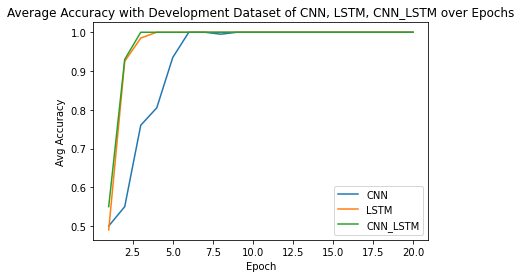

In [81]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, len(test_accuracies_cnn)+1)), test_accuracies_cnn, label = "CNN")
plt.plot(list(range(1, len(test_accuracies_cnn)+1)), test_accuracies_lstm, label = "LSTM")
plt.plot(list(range(1, len(test_accuracies_cnn)+1)), test_accuracies_cnn_lstm, label = "CNN_LSTM")

plt.xlabel('Epoch')
# Set the y axis label of the current axis.
plt.ylabel('Avg Accuracy')
# Set a title of the current axes.
plt.title('Average Accuracy with Development Dataset of CNN, LSTM, CNN_LSTM over Epochs')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

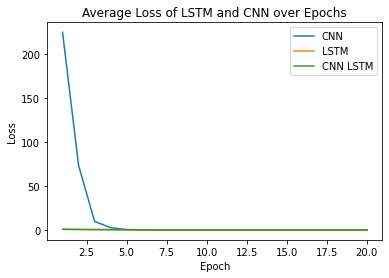

In [82]:

plt.plot(list(range(1, len(losses_cnn)+1)), losses_cnn, label = "CNN")
plt.plot(list(range(1, len(losses_cnn)+1)), losses_lstm, label = "LSTM")
plt.plot(list(range(1, len(losses_cnn)+1)), losses_cnn_lstm, label = "CNN LSTM")
plt.xlabel('Epoch')
# Set the y axis label of the current axis.
plt.ylabel('Loss')
# Set a title of the current axes.
plt.title('Average Loss of LSTM and CNN over Epochs')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [83]:
summarize_results(result_cnn)
summarize_results(result_lstm)
summarize_results(result_cnn_lstm)

[60.00000238418579, 69.9999988079071, 69.9999988079071, 80.0000011920929, 60.00000238418579, 60.00000238418579, 89.99999761581421, 89.99999761581421, 69.9999988079071, 69.9999988079071]
Accuracy: 72.000% (+/-10.770)
[60.00000238418579, 60.00000238418579, 30.000001192092896, 80.0000011920929, 69.9999988079071, 80.0000011920929, 69.9999988079071, 69.9999988079071, 80.0000011920929, 80.0000011920929]
Accuracy: 68.000% (+/-14.697)
[69.9999988079071, 69.9999988079071, 89.99999761581421, 80.0000011920929, 69.9999988079071, 69.9999988079071, 69.9999988079071, 89.99999761581421, 69.9999988079071, 89.99999761581421]
Accuracy: 77.000% (+/-9.000)
